# Conformal prediction & Fuzzy time series

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/Users/philippebeliveau/Desktop/Notebook/Fuzzy_TS_Conformal_Prediction/Fuzzy_FTS/Electricity_data/powerconsumption.csv")

df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


<function matplotlib.pyplot.show(close=None, block=None)>

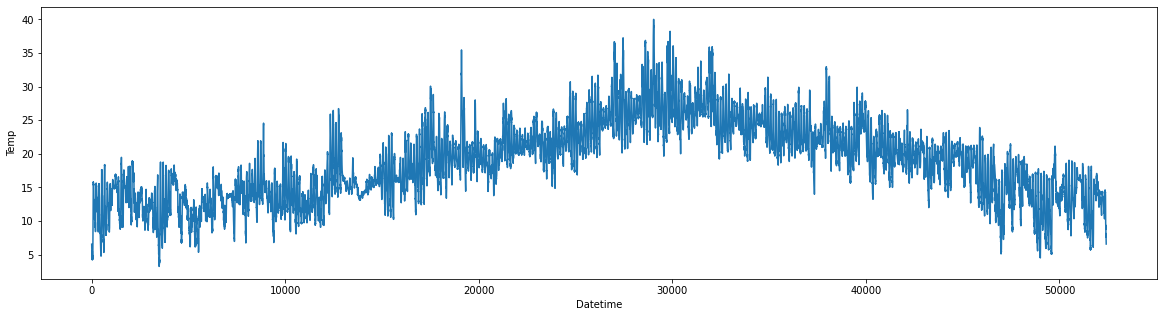

In [4]:
plt.figure(figsize=(20,5))
plt.plot(df["Temperature"])

plt.xlabel("Datetime")
plt.ylabel("Temp")
plt.show

## Number of zeros

In [4]:
df.eq(0).sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

# WPE

In [5]:
x = df['Temperature']
results = [x]
results = np.concatenate(results).ravel().tolist()

In [8]:
import ordpy
from ordpy import weighted_permutation_entropy

entropy = weighted_permutation_entropy(results, dx = 3, dy = 1, normalized=True)
entropy

0.617797761361712

## Transformation
We can use pyFTS own transformations tool. Although, I am not sure how are we going to integrate our own transformation in the partionning function.

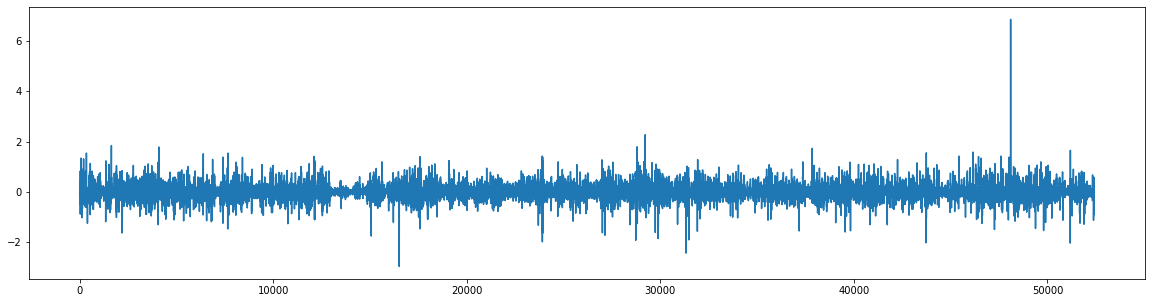

In [5]:
from pyFTS.common import Transformations

diff = Transformations.Differential(1)
fig = plt.subplots(figsize=(20,5))
plt.plot(diff.apply(df["Temperature"].values), label="Temperature")
pass

# Conformal prediction 
## Steps
- Before you start: Check the Awesome CP repo1 to see if a suitable conformal predictor already exists
- Identify or create an uncertainty heuristic for your model
- Turn the heuristic notion of uncertainty into a score of non-conformity
- Start with the general recipe for conformal prediction, but with your (new) non-conformity score
- Optional: Adjust parts of the recipe
- Evaluate your new conformal predictor

## Step 1 Find a suitable conformal predictor
- https://mapie.readthedocs.io/en/latest/examples_regression/4-tutorials/plot_ts-tutorial.html

## Step 2 Identify an uncertainty heuristic for your model
Example:
- Class probabilities → cumulated probabilities (up to true class)
- Class probabilities → probability (of true class)
- Prediction variance → standardized residuals
- Quantile range → distance to the next interval (negative within the range, positive outside)

## Step 3 Turn the heuristic notion into a non-conformity score 
The non-conformity score is then the measure for which we find the threshold using the calibration data.

The non-conformity score is the biggest differentiator between conformal predic- tors.
Conformal predictors may also differ in other parts of the recipe, but the non- conformity score makes or breaks the conformal predictor.

That’s because you have a lot of freedom to choose one and still end up with a conformal predictor, which means the marginal coverage will be fine. But if you use an inappropriate score, the prediction sets or intervals will be super large, and the conditional coverage will be in the far distance.

A few tips for choosing a non-conformity score:
• The score should be small for “certain” predictions and large for uncertain predictions
• The better the score is at ranking predictions by uncertainty, the tighter and more adaptive your prediction regions will be
• The score must be 1-dimensional

Often we don’t get the non-conformity score from the model. But for many models, there’s at least a heuristic uncertainty measure that we can transform.

# Train test split
Only the training data seems to be partionned. 

### Smaller set

In [6]:
#df['DATE'] = pd.to_datetime(df["Datetime"], format='%Y-%m-%d')
train = df.iloc[:40000]
test = df.iloc[40000:54000]

uni_train = train["Temperature"].values
multi_train = train

uni_test = test['Temperature'].values
multi_test = test

# Training phase

## Step 1 - Universe of Discourse partitioning: 
partitioning is the most significant part of training phase. It is applied
to split the Universe of Discourse U into fuzzy sets by making linguistic values A˜ through various types of
available techniques in the literature.

In [7]:
from pyFTS.common import Util
from pyFTS.benchmarks import Measures
from pyFTS.partitioners import Grid,  Entropy #, Huarng
from pyFTS.models import hofts
from pyFTS.common import Membership as mf
from pyFTS.partitioners import CMeans, Grid, FCM, Huarng, Entropy, Util as pUtil
from pyFTS.data import Enrollments

## Exploring the partitioning effects on transformed data
If you want to see the manifold of the error given the number of partitions, check this notebook
https://github.com/PYFTS/notebooks/blob/master/Severiano_et_al_HighOrderFTS.ipynb

# Effect of transformation

## Univariate

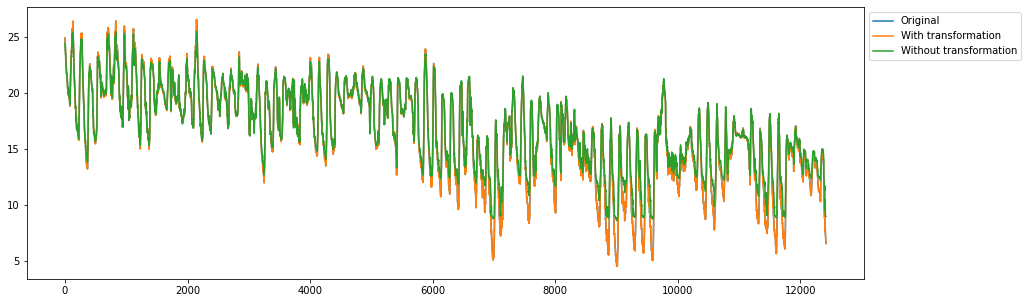

In [8]:
from pyFTS.models import chen, pwfts
from pyFTS.partitioners import Grid

part1 = Grid.GridPartitioner(data=uni_train, npart=10, transformation=diff)
part2 = Grid.GridPartitioner(data=uni_train, npart=10)

model1 = pwfts.ProbabilisticWeightedFTS(partitioner=part1)
model1.append_transformation(diff)
model1.fit(uni_train)

model2 = pwfts.ProbabilisticWeightedFTS(partitioner=part2)
model2.fit(uni_train)

forecasts1 = model1.predict(uni_test)
forecasts2 = model2.predict(uni_test)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(uni_test, label='Original')
ax.plot(forecasts1, label='With transformation')
ax.plot(forecasts2, label='Without transformation')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
     

In [26]:
print(model2)

Probabilistic FTS:
(0.978) A0 -> (0.979)A0, (0.021)A1, (0.0)A2, (0.0)A3, (0.0)A4
(0.022) A1 -> (0.959)A0, (0.039)A1, (0.001)A2, (0.0)A3, (0.0)A4
(0.0) A2 -> (0.458)A0, (0.28)A1, (0.243)A2, (0.019)A3
(0.0) A3 -> (0.633)A0, (0.288)A1, (0.08)A2
(0.0) A4 -> (0.497)A0, (0.503)A1



### Without transformation

In [28]:
rows = []
rmse, smape, u = Measures.get_point_statistics(uni_test, model2)
  
rows.append([model2.shortname, rmse, smape, u])
pd.DataFrame(rows, columns=['Model','RMSE','SMAPE','U'])

,Model,RMSE,SMAPE,U
0,PWFTS,4.15,88.05,0.81


### With transformation

In [29]:
rows = []
rmse, smape, u = Measures.get_point_statistics(uni_test, model1)
  
rows.append([model1.shortname, rmse, smape, u])
pd.DataFrame(rows, columns=['Model','RMSE','SMAPE','U'])

,Model,RMSE,SMAPE,U
0,PWFTS,5.05,96.21,0.99


## Multivariate

/Users/philippebeliveau/Library/Python/3.9/lib/python/site-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


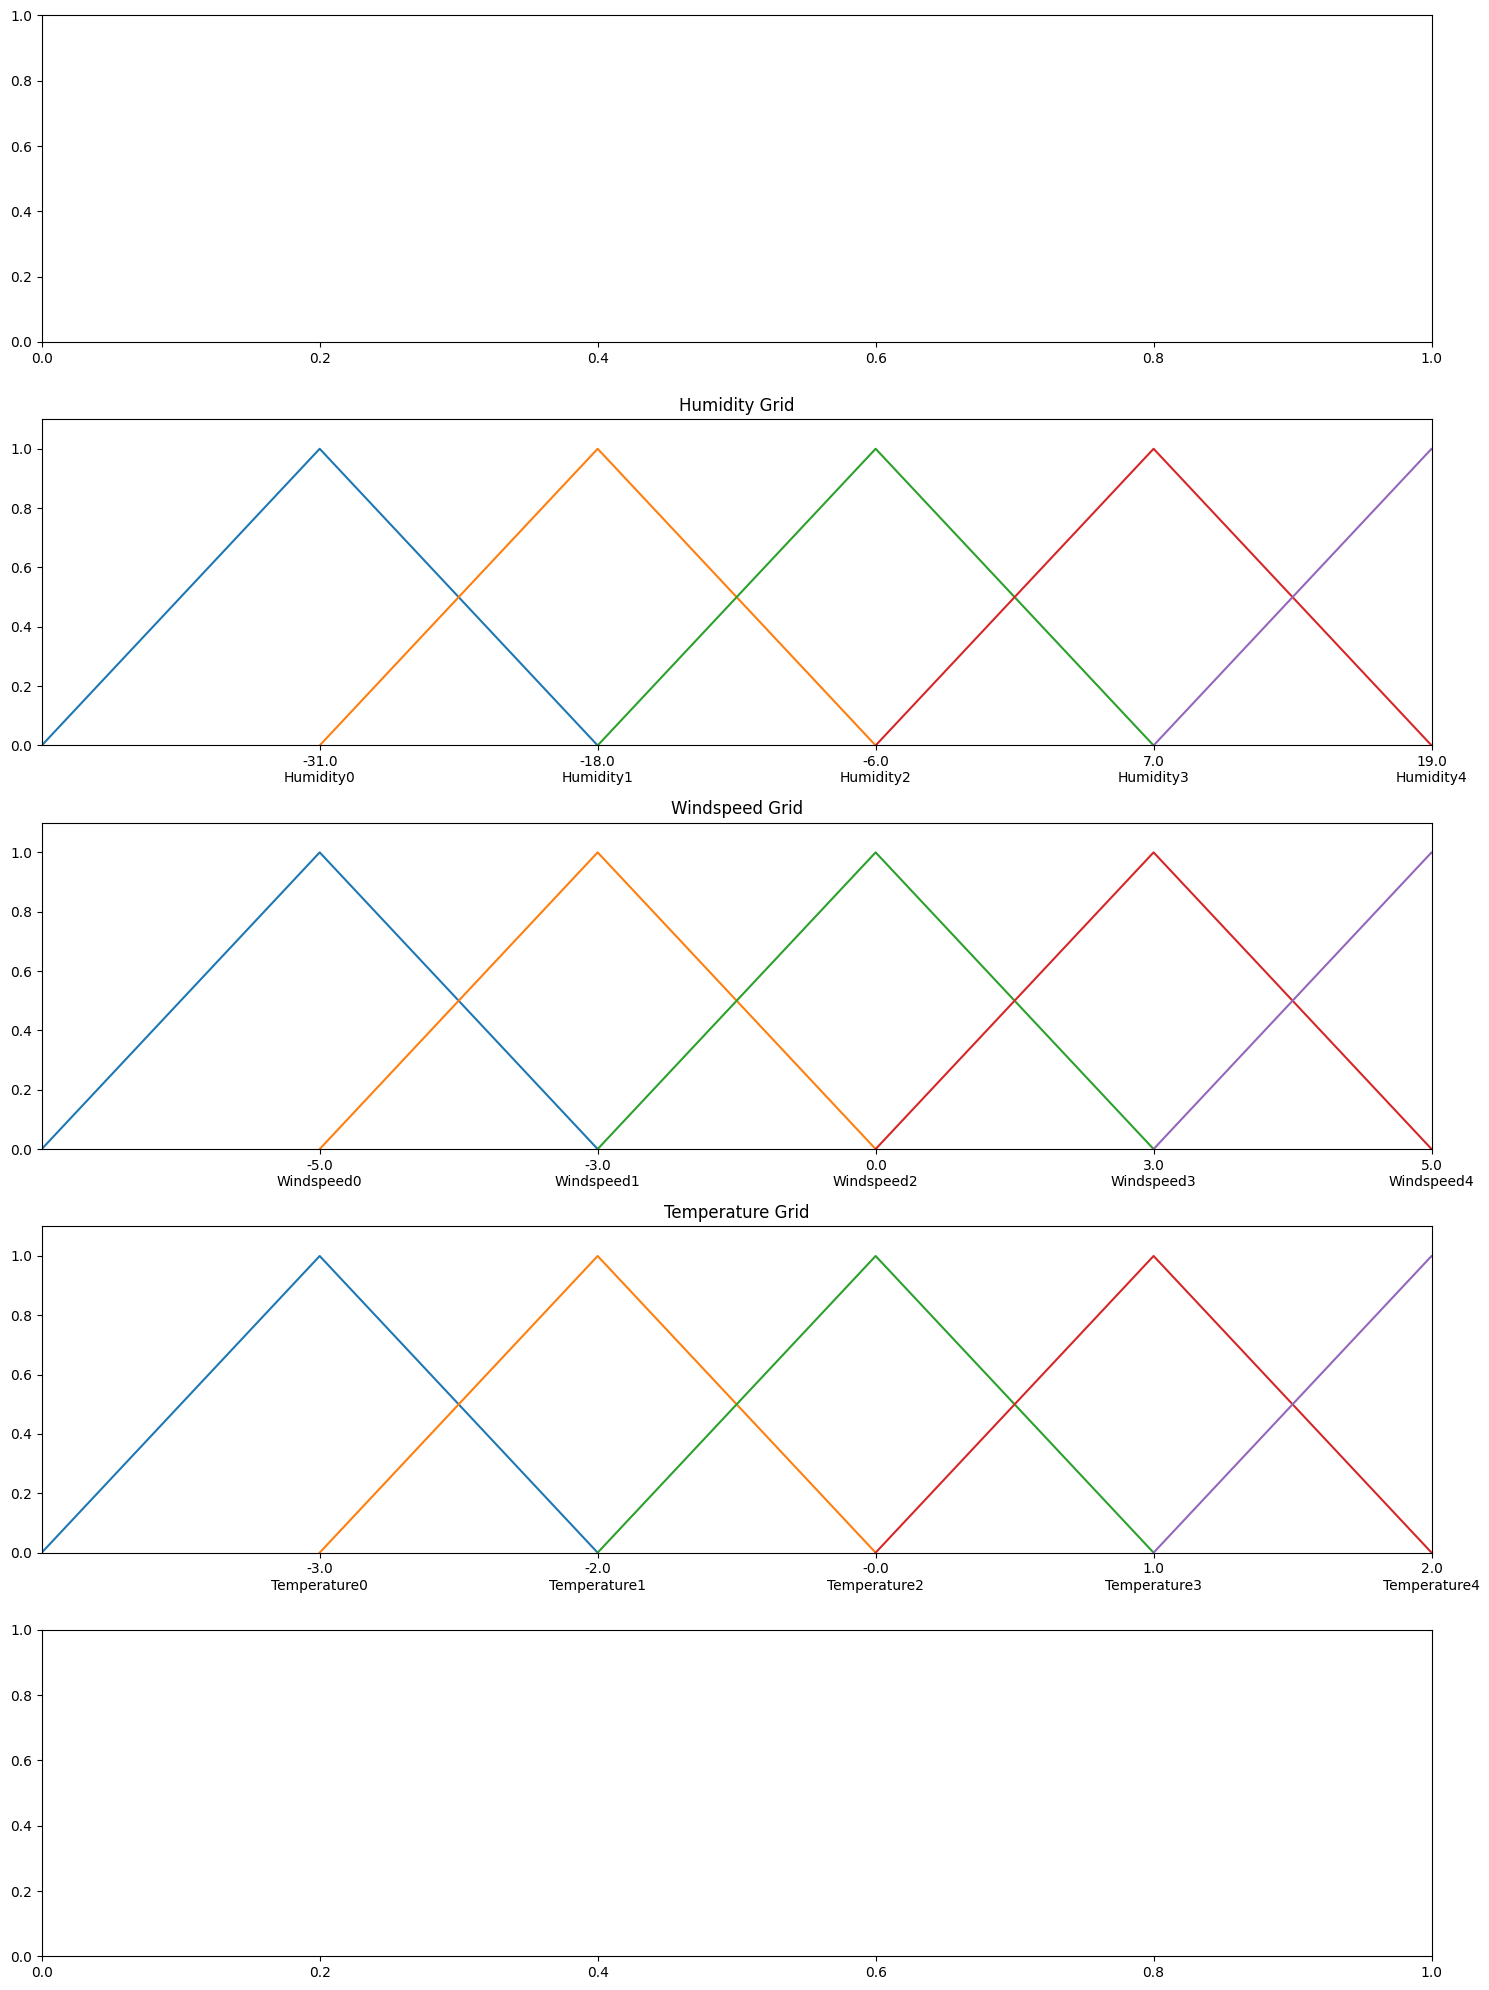

In [21]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.partitioners import Grid

model = mvfts.MVFTS() # should be mvfts.MVFTS("")
diff = Transformations.Differential(1)

fig, axes = plt.subplots(nrows=5, ncols=1,figsize=[15,20])

sp = {'seasonality': DateTime.day_of_year , 'names': ['Jan','Fev','Mar','Abr','Mai','Jun','Jul', 'Ago','Set','Out','Nov','Dez']}

#month = variable.Variable("Month", data_label="Datetime", partitioner=seasonal.TimeGridPartitioner, npart=12, 
#                           data=multi_train, partitioner_specific=sp)
#month.partitioner.plot(axes[4])
#model.append_variable(month)

#sp = {'seasonality': DateTime.day_of_month , 'names': [str(k) for k in range(0,30)]}

#Date = variable.Variable("DATE", data_label="Datetime", partitioner=seasonal.TimeGridPartitioner, npart=30, data=multi_train, partitioner_specific=sp)
#Date.partitioner.plot(axes[0])
#model.append_variable(Date)

humidity = variable.Variable("Humidity", data_label="Humidity", partitioner=Grid.GridPartitioner, npart=5, data=multi_train,
                              transformation=diff)
humidity.partitioner.plot(axes[1])
model.append_variable(humidity)

wind = variable.Variable("Windspeed", data_label="WindSpeed", partitioner=Grid.GridPartitioner, npart=5, alpha_cut=.0, data=multi_train, 
                          transformation=diff) 
wind.partitioner.plot(axes[2])
model.append_variable(wind)

Temp = variable.Variable("Temperature", data_label="Temperature", partitioner=Grid.GridPartitioner, npart=5, data=multi_train, 
                          transformation=diff)
Temp.partitioner.plot(axes[3])
model.target_variable =Temp

plt.tight_layout()

### Model training

In [22]:
model.fit(multi_train, num_batches=10)
forecasted = model.forecast(multi_test)

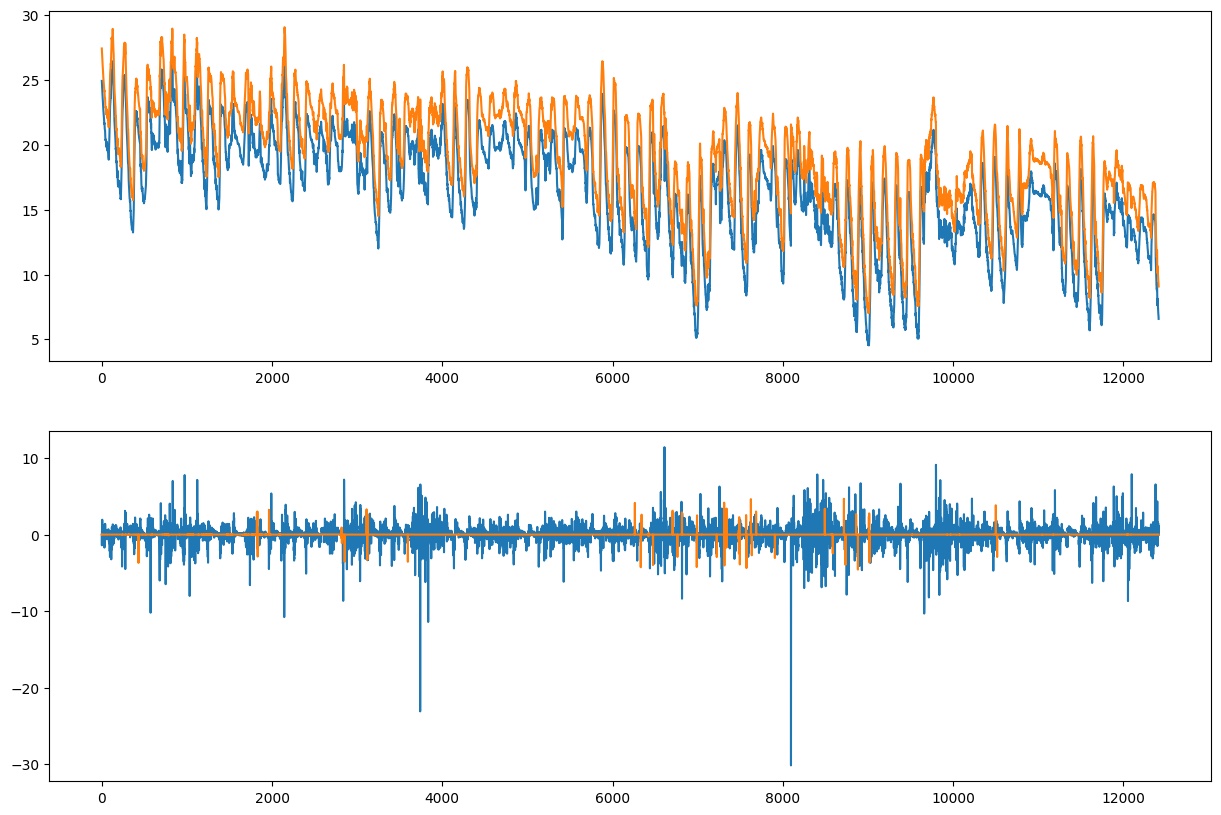

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=[15,10])
ax[0].plot(multi_test["Temperature"].values, label="Temperature")

ax[1].plot(diff.apply(multi_test["Humidity"].values, label="Open"))
ax[1].plot(diff.apply(multi_test["WindSpeed"].values, label="Higher"))

ax[0].plot(forecasted)

plt.show()

In [25]:
model

# Step 4 Apply the conformal recipe

### Source code for mapie.regression.time_series_regression
https://mapie.readthedocs.io/en/latest/_modules/mapie/regression/time_series_regression.html?highlight=MapieTimeSeriesRegressor

In [24]:
import warnings

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.subsample import BlockBootstrap
from mapie.regression import MapieTimeSeriesRegressor

warnings.simplefilter("ignore")

In [26]:
alpha = 0.05
gap = 1
cv_mapiets = BlockBootstrap(
    n_resamplings=100, length=48, overlapping=True, random_state=59
)
mapie_enbpi = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)

### X_train, y_train

In [32]:
X_train = multi_train[['Humidity', 'WindSpeed']]
y_train = multi_train['Temperature']
X_test = multi_test[['Humidity', 'WindSpeed']]
y_test = multi_test['Temperature']

### Partial fit

In [ ]:
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_pfit = np.zeros(y_pred_npfit.shape)
y_pis_pfit = np.zeros(y_pis_npfit.shape)
conformity_scores_pfit = []
lower_quantiles_pfit = []
higher_quantiles_pfit = []
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True
)
for step in range(gap, len(X_test), gap):
    mapie_enbpi.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_pfit[step:step + gap],
        y_pis_pfit[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True
    )
    conformity_scores_pfit.append(mapie_enbpi.conformity_scores_)
    lower_quantiles_pfit.append(mapie_enbpi.lower_quantiles_)
    higher_quantiles_pfit.append(mapie_enbpi.higher_quantiles_)
coverage_pfit = regression_coverage_score(
    y_test, y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)
width_pfit = regression_mean_width_score(
    y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)

In [ ]:
y_preds = [y_pred_npfit, y_pred_pfit]
y_pis = [y_pis_npfit, y_pis_pfit]
coverages = [coverage_npfit, coverage_pfit]
widths = [width_npfit, width_pfit]

fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
)
for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
    ax.set_ylabel("Hourly demand (GW)")
    ax.plot(
        y_train[int(-len(y_test)/2):],
        lw=2,
        label="Training data", c="C0"
    )
    ax.plot(y_test, lw=2, label="Test data", c="C1")

    ax.plot(
        y_test.index, y_preds[i], lw=2, c="C2", label="Predictions"
    )
    ax.fill_between(
        y_test.index,
        y_pis[i][:, 0, 0],
        y_pis[i][:, 1, 0],
        color="C2",
        alpha=0.2,
        label="Prediction intervals",
    )
    title = f"EnbPI, {w} update of residuals. "
    title += f"Coverage:{coverages[i]:.3f} and Width:{widths[i]:.3f}"
    ax.set_title(title)
    ax.legend()
fig.tight_layout()
plt.show()

## Investigate the coverage

In [ ]:
window = 24
rolling_coverage_pfit, rolling_coverage_npfit = [], []
for i in range(window, len(y_test), 1):
    rolling_coverage_pfit.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_pfit[i-window:i, 0, 0],
            y_pis_pfit[i-window:i, 1, 0]
        )
    )
    rolling_coverage_npfit.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_npfit[i-window:i, 0, 0],
            y_pis_npfit[i-window:i, 1, 0]
        )
    )

plt.figure(figsize=(10, 5))
plt.ylabel(f"Rolling coverage [{window} hours]")
plt.plot(
    y_test[window:].index,
    rolling_coverage_npfit,
    label="Without update of residuals"
)
plt.plot(
    y_test[window:].index,
    rolling_coverage_pfit,
    label="With update of residuals"
)
plt.show()